In [111]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import preprocessing 
import transformers
from transformers import AutoModel, BertTokenizerFast

In [3]:
# specify device
device = torch.device("cpu")

In [170]:
df = pd.read_table("input_data.tsv")
df.head()

,propertyId,propertyName,propertyDescription,passageText
0,9,EDUCATED_AT,Describes the relationship between a person an...,When she founded Apex Legal Document Preparati...
1,1,SUBSIDIARY_OF,Describes the relationship between a parent co...,Tata Chemicals Europe (formerly Brunner Mond (...
2,14,DATE_OF_DEATH,Describes the date of death of a person.,After five successful albums and extensive tou...
3,10,NATIONALITY,Describes he country of a person's citizenship...,He is a member of Phi Beta Kappa and was a Ful...
4,10,NATIONALITY,Describes he country of a person's citizenship...,H.E. Sheikh Abdullah bin Mohammed bin Saud Al ...


In [156]:
df.shape

(3977, 4)

In [157]:
df['propertyName'].value_counts(normalize = True)

PLACE_OF_BIRTH           0.119940
DATE_FOUNDED             0.078200
EMPLOYEE_OR_MEMBER_OF    0.077948
SUBSIDIARY_OF            0.077445
HEADQUARTERS             0.072165
POLITICAL_AFFILIATION    0.068645
NATIONALITY              0.064622
CHILD_OF                 0.063113
DATE_OF_DEATH            0.062107
DATE_OF_BIRTH            0.057581
EDUCATED_AT              0.054815
FOUNDED_BY               0.054312
PLACE_OF_RESIDENCE       0.051798
CEO                      0.050792
SPOUSE                   0.046517
Name: propertyName, dtype: float64

In [216]:
label_encoder = preprocessing.LabelEncoder() 
  
# Encode labels in column 'species'. 
df['encodedpropertyName']= label_encoder.fit_transform(df['propertyName']) 
  
df['encodedpropertyName'].unique() 

array([ 5, 14,  4,  9,  8,  7, 13,  0, 11,  2, 12, 10,  6,  1,  3])

In [200]:
train_text, val_text, train_labels, val_labels = train_test_split(df['passageText'], df['encodedpropertyName'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=df['propertyId'])

test_df = pd.read_table("test_data.tsv")

In [201]:
test_text = test_df['passageText']

In [117]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [118]:
# sample data
text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

In [119]:
print(sent_id)

{'input_ids': [[101, 2023, 2003, 1037, 14324, 2944, 14924, 4818, 102, 0], [101, 2057, 2097, 2986, 1011, 8694, 1037, 14324, 2944, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


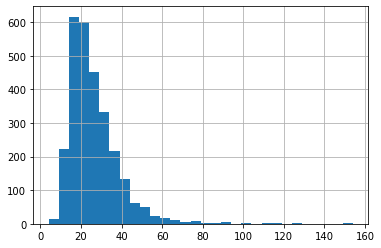

In [120]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [121]:
max_seq_len = 25

In [202]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/home/ubuntu/anaconda3/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1938: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [203]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])

In [124]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [125]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [132]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,15)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [133]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to device
model = model.to(device)

In [139]:
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

In [140]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight('balanced', np.unique(train_labels), train_labels)

print(class_wts)

[1.31583924 1.05416667 0.85107034 1.15958333 1.07244701 1.21263617
 0.85499232 1.22869757 0.92305141 1.03074074 0.55548902 1.28842593
 0.97137871 1.43824289 0.86294574]


In [141]:
# convert class weights to tensor
# weights= torch.tensor(class_wts,dtype=torch.float)
# weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss() 

# number of training epochs
epochs = 10

In [142]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [143]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [144]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
  Batch    50  of     87.

Evaluating...

Training Loss: 2.671
Validation Loss: 2.609

 Epoch 2 / 10
  Batch    50  of     87.

Evaluating...

Training Loss: 2.563
Validation Loss: 2.450

 Epoch 3 / 10
  Batch    50  of     87.

Evaluating...

Training Loss: 2.453
Validation Loss: 2.414

 Epoch 4 / 10
  Batch    50  of     87.

Evaluating...

Training Loss: 2.355
Validation Loss: 2.331

 Epoch 5 / 10
  Batch    50  of     87.

Evaluating...

Training Loss: 2.318
Validation Loss: 2.325

 Epoch 6 / 10
  Batch    50  of     87.

Evaluating...

Training Loss: 2.275
Validation Loss: 2.221

 Epoch 7 / 10
  Batch    50  of     87.

Evaluating...

Training Loss: 2.263
Validation Loss: 2.176

 Epoch 8 / 10
  Batch    50  of     87.

Evaluating...

Training Loss: 2.185
Validation Loss: 2.161

 Epoch 9 / 10
  Batch    50  of     87.

Evaluating...

Training Loss: 2.168
Validation Loss: 2.130

 Epoch 10 / 10
  Batch    50  of     87.

Evaluating...

Training Loss: 2.139
Validation L

In [145]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [204]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [205]:
preds = np.argmax(preds, axis = 1)

In [206]:
preds

array([12,  5,  0, ...,  2,  2,  2])

### Getting the predictions out

In [217]:
label_encoder.classes_

array(['CEO', 'CHILD_OF', 'DATE_FOUNDED', 'DATE_OF_BIRTH',
       'DATE_OF_DEATH', 'EDUCATED_AT', 'EMPLOYEE_OR_MEMBER_OF',
       'FOUNDED_BY', 'HEADQUARTERS', 'NATIONALITY', 'PLACE_OF_BIRTH',
       'PLACE_OF_RESIDENCE', 'POLITICAL_AFFILIATION', 'SPOUSE',
       'SUBSIDIARY_OF'], dtype=object)

In [218]:
label_encoder.inverse_transform(preds)

array(['POLITICAL_AFFILIATION', 'EDUCATED_AT', 'CEO', ..., 'DATE_FOUNDED',
       'DATE_FOUNDED', 'DATE_FOUNDED'], dtype=object)

In [209]:
test_df["propertyName"] = label_encoder.inverse_transform(preds)

In [210]:
test_df

,passageText,passageId,propertyName
0,"He is also chairman of Think Tank of Pakistan,...",14752:1502:1843,POLITICAL_AFFILIATION
1,He is PhD in Mass Communication and Gold Medal...,14752:399:623,EDUCATED_AT
2,Dr Muhammad Ather Khurram is Chief Executive O...,14752:27:189,CEO
3,He was born in Glasgow the son of Thomas Thoms...,14194:254:346,POLITICAL_AFFILIATION
4,"Rex G. Maughan is the founder, president, and ...",7038:13:188,CEO
...,...,...,...
1449,Groove was initially developed by Lotus Notes ...,5316:907:1095,DATE_FOUNDED
1450,"In 1987, the privately held company was fully ...",19897:429:583,DATE_FOUNDED
1451,The station is owned by the Fox Television Sta...,1533:136:219,DATE_FOUNDED
1452,It was built for Howard & Wyndham Ltd under it...,17680:77:263,DATE_FOUNDED


In [211]:
df[["propertyId","propertyName","propertyDescription"]].drop_duplicates()

,propertyId,propertyName,propertyDescription
0,9,EDUCATED_AT,Describes the relationship between a person an...
1,1,SUBSIDIARY_OF,Describes the relationship between a parent co...
2,14,DATE_OF_DEATH,Describes the date of death of a person.
3,10,NATIONALITY,Describes he country of a person's citizenship...
5,6,HEADQUARTERS,Describes the specific location where an organ...
10,2,FOUNDED_BY,Describes the relationship between an organiza...
11,25,SPOUSE,Describes the relationship between a person an...
13,4,CEO,Describes the relationship between an organiza...
18,11,PLACE_OF_RESIDENCE,Describes the relationship between a person an...
20,5,DATE_FOUNDED,Describes the founding date of a company.


In [212]:
final_test_df = pd.merge(test_df, df[["propertyId","propertyName","propertyDescription"]].drop_duplicates(),how="left", on="propertyName")

In [213]:
final_test_df.to_csv("output.tsv",sep="\t", index=False)

In [214]:
final_test_df

,passageText,passageId,propertyName,propertyId,propertyDescription
0,"He is also chairman of Think Tank of Pakistan,...",14752:1502:1843,POLITICAL_AFFILIATION,45,Describes the relationship between a person an...
1,He is PhD in Mass Communication and Gold Medal...,14752:399:623,EDUCATED_AT,9,Describes the relationship between a person an...
2,Dr Muhammad Ather Khurram is Chief Executive O...,14752:27:189,CEO,4,Describes the relationship between an organiza...
3,He was born in Glasgow the son of Thomas Thoms...,14194:254:346,POLITICAL_AFFILIATION,45,Describes the relationship between a person an...
4,"Rex G. Maughan is the founder, president, and ...",7038:13:188,CEO,4,Describes the relationship between an organiza...
...,...,...,...,...,...
1449,Groove was initially developed by Lotus Notes ...,5316:907:1095,DATE_FOUNDED,5,Describes the founding date of a company.
1450,"In 1987, the privately held company was fully ...",19897:429:583,DATE_FOUNDED,5,Describes the founding date of a company.
1451,The station is owned by the Fox Television Sta...,1533:136:219,DATE_FOUNDED,5,Describes the founding date of a company.
1452,It was built for Howard & Wyndham Ltd under it...,17680:77:263,DATE_FOUNDED,5,Describes the founding date of a company.
